In [34]:
import pandas as pd
import matplotlib.pyplot as plt


In [35]:
from google.colab import drive
drive.mount('/content/drive/')
data_path = '/content/drive/MyDrive/Fraud_Detection/Fraud.csv'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [36]:
# Load the dataset
data = pd.read_csv(data_path)
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [37]:
data.describe

<bound method NDFrame.describe of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   

In [38]:
data.columns


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [39]:
# Handling missing values
data.dropna(inplace=True)

In [40]:
# Drop irrelevant columns
data.drop(['step', 'nameOrig', 'nameDest'], axis=1, inplace=True)

In [41]:
# Handling outliers
Q1 = data['amount'].quantile(0.25)
Q3 = data['amount'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['amount'] >= Q1 - 1.5 * IQR) & (data['amount'] <= Q3 + 1.5 * IQR)]


In [42]:
data.describe

<bound method NDFrame.describe of              type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0         PAYMENT    9839.64      170136.00       160296.36            0.00   
1         PAYMENT    1864.28       21249.00        19384.72            0.00   
2        TRANSFER     181.00         181.00            0.00            0.00   
3        CASH_OUT     181.00         181.00            0.00        21182.00   
4         PAYMENT   11668.14       41554.00        29885.86            0.00   
...           ...        ...            ...             ...             ...   
6362609  CASH_OUT  258355.42      258355.42            0.00        25176.67   
6362610  TRANSFER   63416.99       63416.99            0.00            0.00   
6362611  CASH_OUT   63416.99       63416.99            0.00       276433.18   
6362614  TRANSFER  339682.13      339682.13            0.00            0.00   
6362615  CASH_OUT  339682.13      339682.13            0.00            0.00   

         newbalan

#One-Hot encoding for 'type'




In [43]:
df = pd.get_dummies(data, columns=['type'], prefix=['type'])
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0


In [44]:
rows_to_drop = int(0.98 * len(df))

# Randomly select rows to drop
rows_to_drop_indices = df.sample(n=rows_to_drop, random_state=42).index

# Drop the selected rows
df_dropped = df.drop(rows_to_drop_indices)

In [45]:
df = df_dropped

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [47]:
# Split data into features (X) and target (y)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [48]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
# Initialize classifiers
rf_classifier = RandomForestClassifier()
gb_classifier = GradientBoostingClassifier()
svc_classifier = SVC()
knn_classifier = KNeighborsClassifier()

In [51]:
# Fit classifiers on the training data
rf_classifier.fit(X_train_scaled, y_train)
gb_classifier.fit(X_train_scaled, y_train)
svc_classifier.fit(X_train_scaled, y_train)
knn_classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [52]:
# Predictions
y_pred_rf = rf_classifier.predict(X_test_scaled)
y_pred_gb = gb_classifier.predict(X_test_scaled)
y_pred_svc = svc_classifier.predict(X_test_scaled)
y_pred_knn = knn_classifier.predict(X_test_scaled)

In [53]:
# Confusion matrix and accuracy scores
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Confusion Matrix:\n", conf_matrix_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Confusion Matrix:
 [[24083     0]
 [   11     5]]
Random Forest Accuracy: 0.9995435495248766


In [54]:
conf_mat_gb = confusion_matrix(y_test, y_pred_gb)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Confusion Matrix:\n", conf_mat_gb)
print("Gradient Boosting Accuracy: ", accuracy_gb)

Gradient Boosting Confusion Matrix:
 [[24079     4]
 [   11     5]]
Gradient Boosting Accuracy:  0.9993775675339226


In [55]:
conf_mat_svc = confusion_matrix(y_test, y_pred_svc)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print("SVC Confusion Matrix:\n", conf_mat_svc)
print("SVC Accuracy: ", accuracy_svc)

SVC Confusion Matrix:
 [[24083     0]
 [   16     0]]
SVC Accuracy:  0.999336072036184


In [56]:
conf_mat_knn = confusion_matrix(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Confusion Matrix:\n", conf_mat_knn)
print("KNN Accuracy: ", accuracy_knn)

KNN Confusion Matrix:
 [[24083     0]
 [   16     0]]
KNN Accuracy:  0.999336072036184


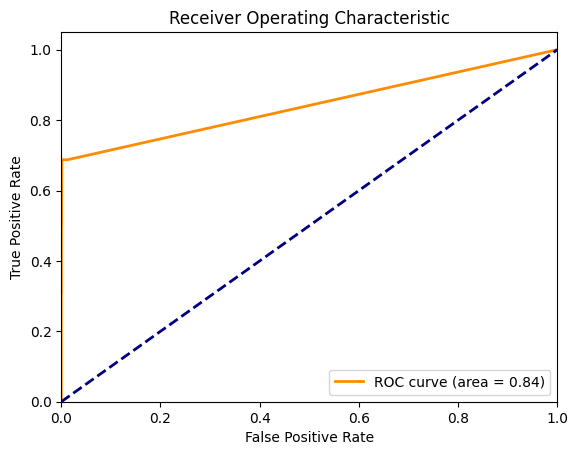

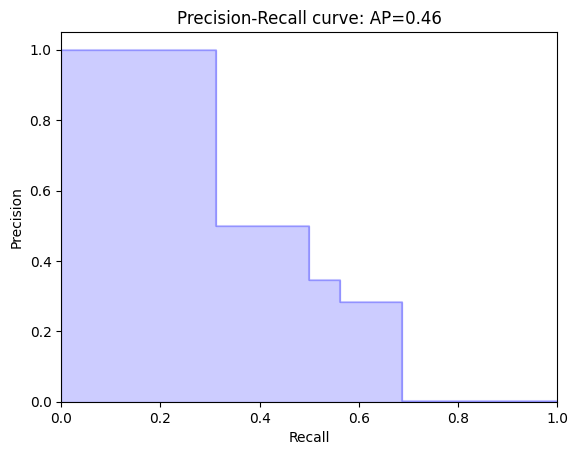

In [57]:
best_model = rf_classifier

# Predict probabilities
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-recall curve and average precision score
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

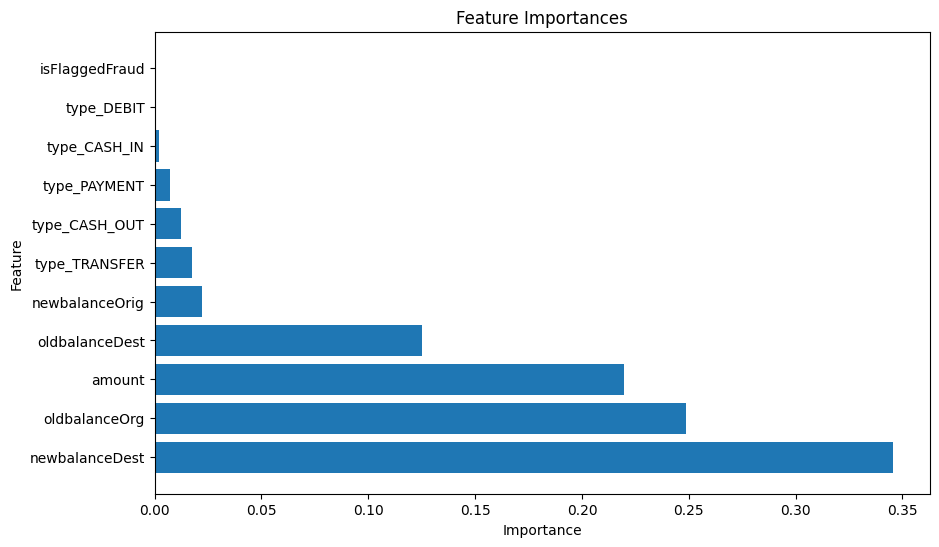

Top 11 Key Factors for Predicting Fraudulent Customers:
           Feature  Importance
4   newbalanceDest    0.345464
1    oldbalanceOrg    0.248667
0           amount    0.219624
3   oldbalanceDest    0.125104
2   newbalanceOrig    0.022064
10   type_TRANSFER    0.017469
7    type_CASH_OUT    0.012430
9     type_PAYMENT    0.007057
6     type_CASH_IN    0.001927
8       type_DEBIT    0.000193
5   isFlaggedFraud    0.000000


In [58]:
best_model = rf_classifier

# Get feature importances from the model
feature_importances = best_model.feature_importances_

# Get the column names from X_train_scaled
column_names = X.columns

# Create a DataFrame to show feature importance
feature_importance_df = pd.DataFrame({'Feature': column_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# Display the top N key factors
top_n = 11  # Change this value to the number of top factors you want to display
print(f'Top {top_n} Key Factors for Predicting Fraudulent Customers:')
print(feature_importance_df.head(top_n))


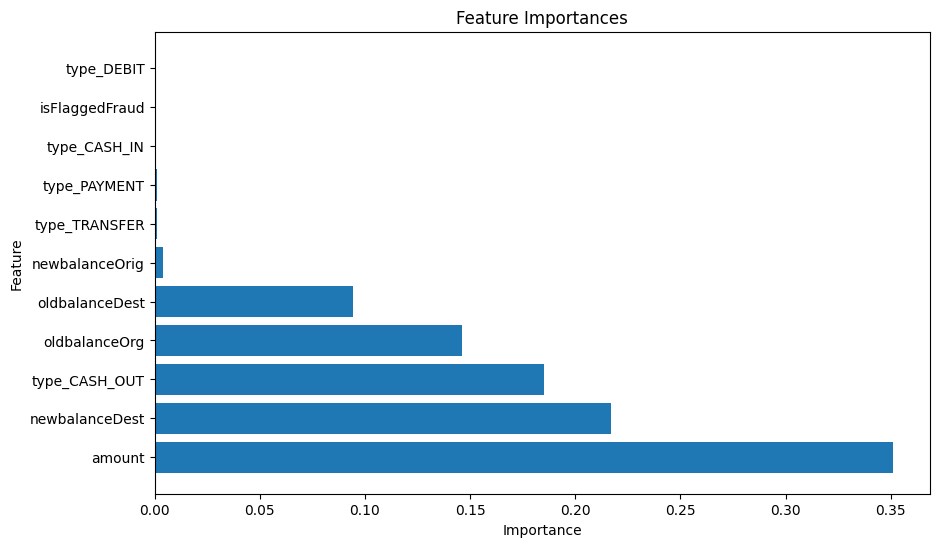

Top 11 Key Factors for Predicting Fraudulent Customers:
           Feature  Importance
0           amount    0.350975
4   newbalanceDest    0.217166
7    type_CASH_OUT    0.185006
1    oldbalanceOrg    0.146226
3   oldbalanceDest    0.094434
2   newbalanceOrig    0.003832
10   type_TRANSFER    0.001265
9     type_PAYMENT    0.001067
6     type_CASH_IN    0.000029
5   isFlaggedFraud    0.000000
8       type_DEBIT    0.000000


In [59]:
best_model = gb_classifier

# Get feature importances from the model
feature_importances = best_model.feature_importances_

# Get the column names from X_train_scaled
column_names = X.columns

# Create a DataFrame to show feature importance
feature_importance_df = pd.DataFrame({'Feature': column_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# Display the top N key factors
top_n = 11  # Change this value to the number of top factors you want to display
print(f'Top {top_n} Key Factors for Predicting Fraudulent Customers:')
print(feature_importance_df.head(top_n))